In [ ]:
import numpy as np
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()

## EDA

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv('./dataset/house_price_train.csv', parse_dates=["Time"])
df_test = pd.read_csv('./dataset/house_price_test.csv', parse_dates=["Time"])

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
px.bar(df_train["City"].value_counts())

In [ ]:
df_subset = df_train[df_train["Time"].dt.year == 2018]["Price"]
price_fft = np.fft.rfft(df_subset.values)
plt.plot(np.abs(price_fft))

In [ ]:
df_train["Time"].min(), df_train["Time"].max()

In [ ]:
df_train.isna().sum()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train.groupby([df_train["Time"].dt.year, df_train["Time"].dt.month])["Price"].mean().plot(kind="line", ax=ax, title="Mean Price")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df_subset = df_train[["Time", "Price"]].set_index("Time").rename(columns={"Price": "data"}).sort_index()
seasonal_decompose(df_subset.loc["2017-01-01":"2017-12-31"], model='multiplicative', period=365).plot()
plt.show()

In [ ]:
sns.histplot(df_train["Price"])

In [ ]:
sns.boxenplot(df_train["Price"])

In [ ]:
df_train["Price"].describe().apply(lambda x: format(x, 'f'))

## Modelling

In [18]:
from sklearn.metrics import r2_score

In [19]:
# evaluation metrics
def log_mean_average_error(y_true, y_pred):
    return np.sum(np.log(y_true) - np.log(y_pred)) / y_true.shape[0]

### Baseline model using OLS

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression

In [ ]:
cat_columns = ["City", "District", "Street", "Community", "Floor"] # "Orient" has too many null values
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_columns = ["#Floors", "#Rooms", "#Halls", "Area"]
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    n_jobs=4,
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns)
])

In [ ]:
# remove outliers using quantile 25%, 75%
df_train_pool = df_train.query("Price > 9993.0 & Price < 31053.75")

X_train, y_train = df_train_pool.iloc[:, :-1], df_train_pool.iloc[:, -1]
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

In [24]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=4,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['#Floors', '#Rooms',
                                                   '#Halls', 'Area']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['City', 'District', 'Street',
                                                   'Community', 'Floor'])])),
                ('regressor', LinearRegression())])

In [25]:
predicted = baseline_model.predict(X_test)
print("Minimum predicted: ", np.min(predicted))
print("Maximum predicted: ", np.max(predicted))
print("R2: ", r2_score(y_test, predicted))
print("MAE_LOG: ", log_mean_average_error(y_test, np.abs(predicted)))
print("MAE_LOG EXP: ", np.exp(log_mean_average_error(y_test, predicted)))

Minimum predicted:  -6728.043668950593
Maximum predicted:  45407.37609040055
R2:  -0.2643258370022954
MAE_LOG:  0.48035662828410103
MAE_LOG EXP:  1.6138428396257458


/tmp/ipykernel_5292/2742011506.py:3: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(y_true) - np.log(y_pred)) / y_true.shape[0]


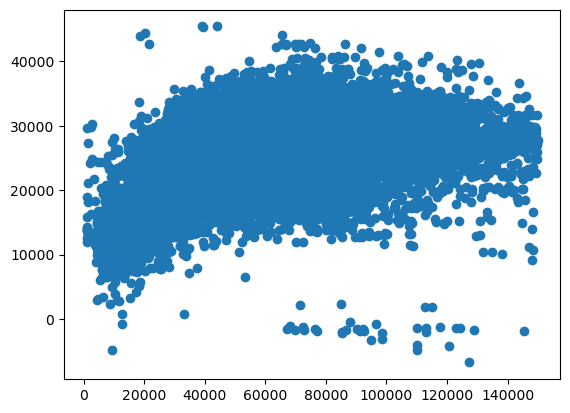

In [26]:
plt.scatter(y_test, predicted)

### Tree based model using CatBoost

In [10]:
from catboost import CatBoostRegressor, Pool

In [12]:
df_train_pool = df_train.drop(columns=["Time", "Orient"])
df_train_pool = df_train_pool.query("Price > 9993.0 & Price < 31053.75") # remove outliers using quantile 25%, 75%

df_test_pool = df_test.drop(columns=["Time", "Orient"])

X_train, y_train = df_train_pool.iloc[:, :-1], df_train_pool.iloc[:, -1]
X_test, y_test = df_test_pool.iloc[:, :-1], df_test_pool.iloc[:, -1]

cat_cols_idx = [i for i, col in enumerate(X_train.columns) if col in cat_columns]


train_pool = Pool(X_train.values, y_train.values, cat_features=cat_cols_idx)
test_pool = Pool(X_test.values, y_test.values, cat_features=cat_cols_idx)

In [13]:
catboost_model = CatBoostRegressor(task_type="GPU", loss_function='RMSE')
catboost_model.fit(train_pool)

Learning rate set to 0.084369
0:	learn: 5628.2622239	total: 44.5ms	remaining: 44.5s
1:	learn: 5385.6820976	total: 79.2ms	remaining: 39.5s
2:	learn: 5173.4181851	total: 119ms	remaining: 39.6s
3:	learn: 4983.7901622	total: 179ms	remaining: 44.5s
4:	learn: 4813.0084673	total: 208ms	remaining: 41.5s
5:	learn: 4663.5674433	total: 249ms	remaining: 41.3s
6:	learn: 4518.3152633	total: 285ms	remaining: 40.4s
7:	learn: 4391.9270781	total: 324ms	remaining: 40.2s
8:	learn: 4288.8838767	total: 379ms	remaining: 41.7s
9:	learn: 4191.2539115	total: 433ms	remaining: 42.9s
10:	learn: 4102.8166405	total: 502ms	remaining: 45.2s
11:	learn: 4022.2541352	total: 566ms	remaining: 46.6s
12:	learn: 3956.3156552	total: 603ms	remaining: 45.8s
13:	learn: 3896.4960214	total: 652ms	remaining: 45.9s
14:	learn: 3835.8896473	total: 691ms	remaining: 45.4s
15:	learn: 3780.9665899	total: 728ms	remaining: 44.8s
16:	learn: 3732.5070855	total: 790ms	remaining: 45.7s
17:	learn: 3689.1028421	total: 853ms	remaining: 46.5s
18:	le

In [20]:
predicted = catboost_model.predict(test_pool)
print("Minimum predicted: ", np.min(predicted))
print("Maximum predicted: ", np.max(predicted))
print("R2: ", r2_score(y_test, predicted))
print("MAE_LOG: ", log_mean_average_error(y_test, predicted))
print("MAE_LOG EXP: ", np.exp(log_mean_average_error(y_test, predicted)))

Minimum predicted:  6905.083531734534
Maximum predicted:  36171.69380112132
R2:  -0.27684066121728734
MAE_LOG:  0.37948595138183727
MAE_LOG EXP:  1.461533097229978


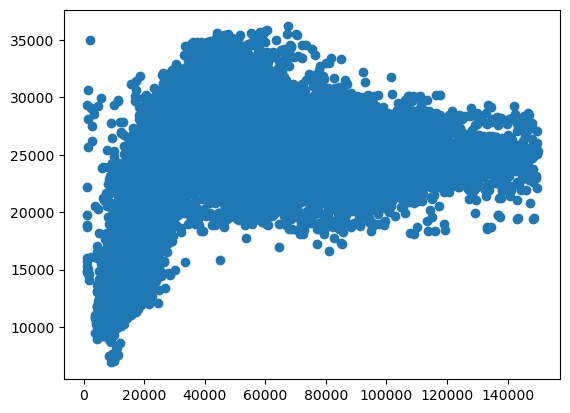

In [16]:
plt.scatter(y_test, predicted)